In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer



# <span style="color:blue">Importing Data</span>

### <span style="color:red">Our dataset consists of the following columns:</span>

- <span style="color:grey">**Column 1:**</span> Title of the news
- <span style="color:grey">**Column 2:**</span> Text
- <span style="color:grey">**Column 3:**</span> Subject
- <span style="color:grey">**Column 4:**</span> Date


In [2]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")


In [3]:
df_fake['Label']='Fake'
df_true['Label']='True'

In [4]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

## <span style="color:blue">Observation:</span>
Here we observe that nearly all of the true texts contain the word "Reuters". This presence may lead to overfitting during model training. Hence, we will need to remove it during the data preprocessing stage.

In [5]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1    

In [6]:
j

21247

# <span style="color:blue">Manual Testing Dataset</span>

<!-- Introduction -->
This section introduces the manual testing dataset.

<!-- Description -->
## <span style="color:green">Features</span>
- <span style="color:purple">**Column 1:**</span> Title
- <span style="color:purple">**Column 2:**</span> Text
- <span style="color:purple">**Column 3:**</span> Subject
- <span style="color:purple">**Column 4:**</span> Date

<!-- Purpose -->
# <span style="color:blue">Purpose</span>
This dataset aids in manual testing of the fraud detection model.

<!-- Usage -->
# <span style="color:blue">Usage</span>
Used for manual evaluation of model performance.

<!-- Conclusion -->


In [7]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')



In [8]:
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

# <span style="color:blue">Merging the two Data Sets</span>


In [9]:
df_train= pd.concat([df_fake, df_true], axis=0)

In [10]:
df_train

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [11]:
df_train=df_train.sample(frac=0.5)

# <span style="color:blue">Data Preprocessing</span>

In [12]:
df_train.shape

(22438, 5)

In [13]:
df_train.describe()

,title,text,subject,date,Label
count,22438,22438,22438,22438,22438
unique,20872,20700,8,2355,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",Fake
freq,9,315,5627,102,11703


In [14]:
df_train.head(5)

,title,text,subject,date,Label
4215,Trump appointee Gorsuch energetic in first U.S...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"April 17, 2017",True
1816,Republicans see tax reform complicated by Trum...,WASHINGTON (Reuters) - U.S. Republican party l...,politicsNews,"September 8, 2017",True
5493,Protesters face off as U.S. abortion debate he...,"WASHINGTON/MARIETTA, Ga. (Reuters) - Anti-abor...",politicsNews,"February 11, 2017",True
21105,German SPD leader says EU must stop accession ...,BERLIN (Reuters) - Germany s Social Democrat (...,worldnews,"September 3, 2017",True
12003,THE OBAMAS MILK EVERY LAST MINUTE: Will Throw ...,"Of course, there s no official word from the W...",politics,"Jan 3, 2017",Fake


## <span style="color:blue">Now we will handle duplicates and missing values.</span>
To avoid dropping NA values, we will replace missing values with 'Unknown'.
##### Our Dataset doesn't contain NA values.



In [15]:
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [16]:
df_train.fillna('', inplace=True)

In [17]:
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [18]:
df_train.duplicated().sum()

50

In [19]:
df_train.drop_duplicates(inplace=True)

In [20]:
df_train.duplicated().sum()

0

In [21]:
df_train.reset_index(inplace=True)

In [22]:
df_train

,index,title,text,subject,date,Label
0,4215,Trump appointee Gorsuch energetic in first U.S...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"April 17, 2017",True
1,1816,Republicans see tax reform complicated by Trum...,WASHINGTON (Reuters) - U.S. Republican party l...,politicsNews,"September 8, 2017",True
2,5493,Protesters face off as U.S. abortion debate he...,"WASHINGTON/MARIETTA, Ga. (Reuters) - Anti-abor...",politicsNews,"February 11, 2017",True
3,21105,German SPD leader says EU must stop accession ...,BERLIN (Reuters) - Germany s Social Democrat (...,worldnews,"September 3, 2017",True
4,12003,THE OBAMAS MILK EVERY LAST MINUTE: Will Throw ...,"Of course, there s no official word from the W...",politics,"Jan 3, 2017",Fake
...,...,...,...,...,...,...
22383,12648,German conservatives reject 'United States of ...,BERLIN (Reuters) - Senior members of German Ch...,worldnews,"December 9, 2017",True
22384,1778,U.S. senator on Equifax hack: 'Somebody needs ...,WASHINGTON (Reuters) - Thirty-six U.S. senator...,politicsNews,"September 21, 2017",True
22385,7105,"Italy to push Iran trade ties, undaunted by Trump",ROME (Reuters) - Italy’s industry minister ple...,politicsNews,"November 22, 2016",True
22386,7767,Kremlin says Putin ready to welcome any U.S. c...,MOSCOW (Reuters) - The Kremlin said on Wednesd...,politicsNews,"October 19, 2016",True


## <span style="color:blue">Removing "Reuters" from Dataset</span>
### Although our function successfully removes the word 'Reuters', it still remains in our dataset, albeit occurring only 10 times. Therefore, it is unlikely to cause overfitting issues.

In [23]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text

In [24]:
df_train['text']=df_train['text'].apply(reuters_removal)

In [25]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1 
        
j

7

# Data Visualization

## Analysis

The frequency of <span style="color: red;">fake news</span> is slightly above <span style="color: blue;">true news</span> based on our data.


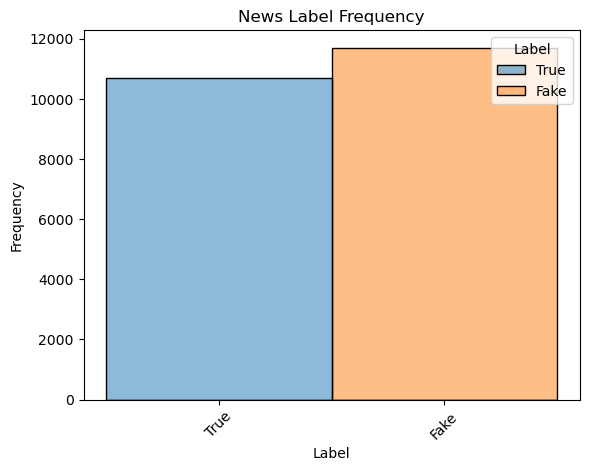

In [26]:
sbs.histplot(x='Label', hue='Label',data=df_train)
plt.title('News Label Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency');



## <span style="color:blue">Analysis: News Content Distribution</span>
Most of the news are about  <span style="color: red;">Politics</span>



In [28]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

subject
politicsNews       5611
worldnews          5075
News               4548
politics           3418
left-news          2166
Government News     800
US_News             396
Middle-east         374
Name: count, dtype: int64

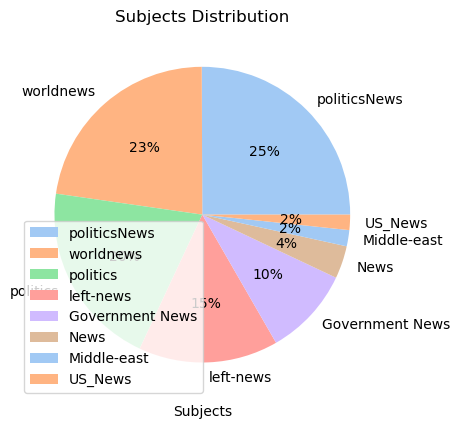

In [29]:
colors = sbs.color_palette('pastel')[0:6]
plt.pie(df_top_group,labels=df_top.subject.unique(),autopct='%.0f%%', colors=colors)
plt.title('Subjects Distribution')
plt.xlabel('Subjects')
plt.legend(df_top.subject.unique(), loc='lower left')
plt.show();


## <span style="color:blue">Observation:</span> <span style="color:red">News Labeling</span>

<span style="color:black">We notice that only news labeled as "<span style="color:green">politicsNews</span>" and "<span style="color:green">Worldnews</span>" are true, while all other subjects are fake.</span>
<span style="color:red"> Therefore, we will not include the Subjects feature in our model to avoid overfitting</span>


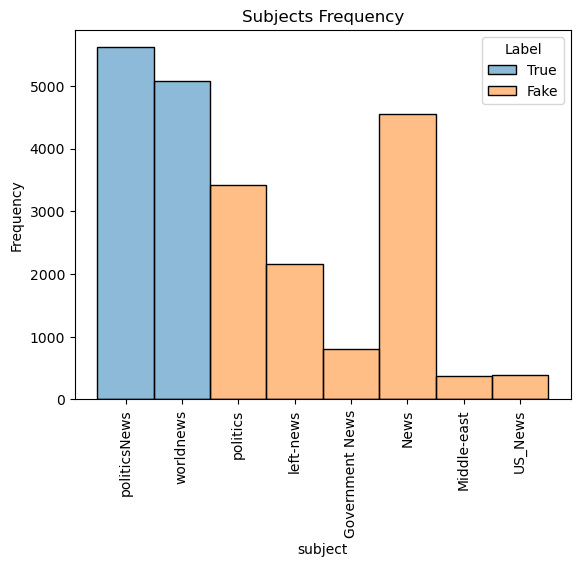

In [30]:
top_parties = df_train['subject'].value_counts().nlargest(5).index
df_top=df_train.copy()
df_top.loc[~df_top['subject'].isin(top_parties), 'Party'] = 'Other'
sbs.histplot(x='subject', hue='Label', data=df_top, stat='count')
plt.title('Subjects Frequency')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show();


In [31]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

# <span style="color:blue">Splitting the Data</span>

## <span style="color:green">Task Description</span>

We will split the dataset into training and testing sets. Additionally, we will encode the labels into numerical values to facilitate the calculation of the reliability percentage of the news articles.


In [32]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)

In [33]:
y.unique()

array(['True', 'Fake'], dtype=object)

In [34]:
X

,title,text,subject
0,Trump appointee Gorsuch energetic in first U.S...,WASHINGTON - President Donald Trump’s appointe...,politicsNews
1,Republicans see tax reform complicated by Trum...,WASHINGTON - U.S. Republican party lawmakers w...,politicsNews
2,Protesters face off as U.S. abortion debate he...,"WASHINGTON/MARIETTA, Ga. - Anti-abortion prote...",politicsNews
3,German SPD leader says EU must stop accession ...,BERLIN - Germany s Social Democrat (SPD) leade...,worldnews
4,THE OBAMAS MILK EVERY LAST MINUTE: Will Throw ...,"Of course, there s no official word from the W...",politics
...,...,...,...
22383,German conservatives reject 'United States of ...,BERLIN - Senior members of German Chancellor A...,worldnews
22384,U.S. senator on Equifax hack: 'Somebody needs ...,WASHINGTON - Thirty-six U.S. senators on Tuesd...,politicsNews
22385,"Italy to push Iran trade ties, undaunted by Trump",ROME - Italy’s industry minister pledged on Tu...,politicsNews
22386,Kremlin says Putin ready to welcome any U.S. c...,MOSCOW - The Kremlin said on Wednesday it was ...,politicsNews


# <span style="color:blue">Stemming and Stop Words</span>

## <span style="color:green">Overview</span>

Stemming and stop words removal are essential preprocessing steps in natural language processing (NLP) tasks. These techniques help in simplifying text data and removing noise, thereby improving the efficiency and accuracy of downstream NLP algorithms.



In [35]:
port_stemmer= PorterStemmer()

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Nidhal
[nltk_data]     Jegham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
def stemmer(content):
    stemmed_content=re.sub('[^a-zA-Z]',' ', content)
    stemmed_content= stemmed_content.lower()
    stemmed_content= stemmed_content.split()
    stemmed_content= [port_stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content= ' '.join(stemmed_content)
    return stemmed_content

In [38]:
X['text']= X['text'].apply(stemmer)


In [39]:
X=X['text']

In [40]:
X

0        washington presid donald trump appointe neil g...
1        washington u republican parti lawmak warn frid...
2        washington marietta ga anti abort protest rall...
3        berlin germani social democrat spd leader mart...
4        cours offici word white hous yet typic obama a...
                               ...                        
22383    berlin senior member german chancellor angela ...
22384    washington thirti six u senat tuesday call fed...
22385    rome itali industri minist pledg tuesday suppo...
22386    moscow kremlin said wednesday readi welcom u p...
22387    washington washington chatter deepen waterg st...
Name: text, Length: 22388, dtype: object

# <span style="color:blue">Train Test Split</span>


In [41]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=40, stratify=y)

# <span style="color:blue">TF-IDF Vectorization</span>

## <span style="color:green">Overview</span>

TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to represent text data numerically. It converts a collection of raw documents into a matrix of TF-IDF features, where each row represents a document and each column represents a unique term in the corpus. TF-IDF takes into account both the frequency of a term in a document (TF) and the rarity of the term across all documents (IDF).

## <span style="color:green">Implementation</span>

In our preprocessing pipeline, we apply TF-IDF vectorization to convert the text data into numerical features. This process involves the following steps:
- **Tokenization**: Breaking down the text into individual words or tokens.
- **TF Calculation**: Computing the frequency of each term in each document.
- **IDF Calculation**: Calculating the inverse document frequency of each term.
- **TF-IDF Computation**: Combining TF and IDF to compute the TF-IDF score for each term in each document.



In [42]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

# <span style="color:blue">Model Training</span>

The Random Forest Model gives us the best accuracy with <span style="color:green">%98</span> and only <span style="color:red">177 False Positives and True Negatives</span>.



# <span style="color:blue"> Random Forest Model
</span>


In [43]:
rfc= RandomForestClassifier()

In [44]:
rfc.fit(xv_train, y_train)

RandomForestClassifier()

In [45]:
y_predicted = rfc.predict(xv_train)
rfc_accuracy = accuracy_score(y_predicted,y_train )

In [46]:
rfc_accuracy

1.0

In [47]:
y_predicted = rfc.predict(xv_test)
rfc_accuracy = accuracy_score(y_predicted,y_test )

In [48]:
rfc_accuracy

0.9720857525681108

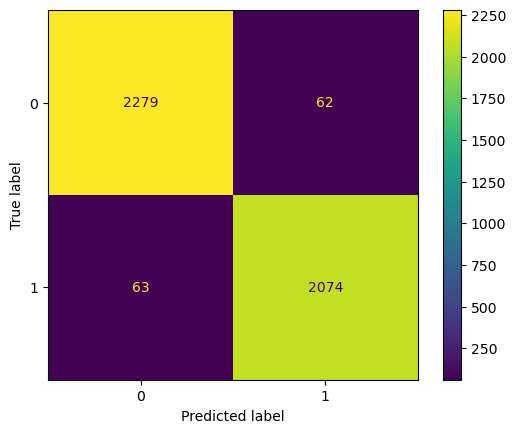

              precision    recall  f1-score   support

        Fake       0.97      0.97      0.97      2341
        True       0.97      0.97      0.97      2137

    accuracy                           0.97      4478
   macro avg       0.97      0.97      0.97      4478
weighted avg       0.97      0.97      0.97      4478



In [49]:
cm = confusion_matrix(y_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, y_predicted))


# <span style="color:blue"> Gradient Boosting
</span>


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gbm= GradientBoostingClassifier()
gbm.fit(xv_train, y_train)
y_predicted = gbm.predict(xv_test)
gbm_accuracy = accuracy_score(y_predicted,y_test )

In [51]:
gbm_accuracy

0.9602501116569897

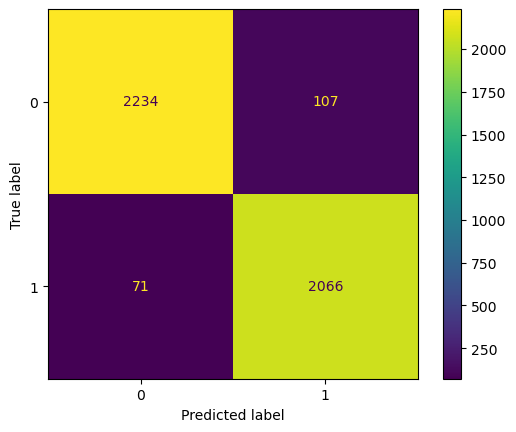

              precision    recall  f1-score   support

        Fake       0.97      0.95      0.96      2341
        True       0.95      0.97      0.96      2137

    accuracy                           0.96      4478
   macro avg       0.96      0.96      0.96      4478
weighted avg       0.96      0.96      0.96      4478



In [52]:
cm = confusion_matrix(y_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, y_predicted))


# <span style="color:blue"> Logistic Regression
</span>


In [53]:
lgr=LogisticRegression(max_iter=1000)

In [54]:
lgr.fit(xv_train,y_train)

LogisticRegression(max_iter=1000)

In [55]:
y_pred=lgr.predict(xv_test)

In [56]:
accuracy_score(y_pred,y_test)

0.9747655203215722

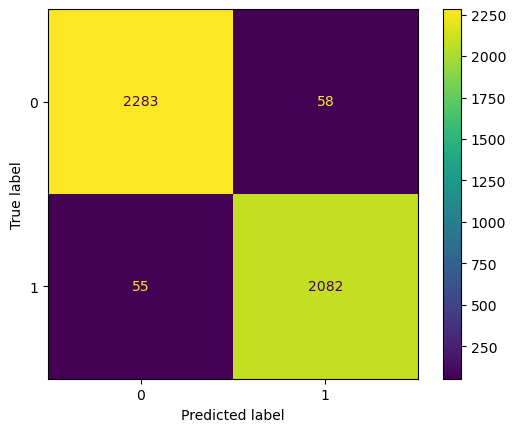

              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      2341
        True       0.97      0.97      0.97      2137

    accuracy                           0.97      4478
   macro avg       0.97      0.97      0.97      4478
weighted avg       0.97      0.97      0.97      4478



In [57]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, y_pred))


# <span style="color:blue"> Manual Testing </span>
### <span style="color:green"> Manual Testing will be useful to test our model on real life data </span>


In [58]:
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(reuters_removal) 

    new_def_test["text"] = new_def_test["text"].apply(stemmer) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    prediction= rfc.predict(new_xv_test)
    return prediction[0]


In [59]:
manual_testing(df_manual.loc[12,'text'])

'True'

In [60]:
df_manual

,title,text,subject,date,Label
0,"Did Ron Paul Just Confuse Al-Qaeda With ISIS,...",Former Texas Congressman Ron Paul added yet mo...,News,"August 22, 2017",Fake
1,Congressional Black Caucus Signals That They ...,"The Congressional Black Caucus, like most Demo...",News,"August 21, 2017",Fake
2,Body-Slamming Republican Thought He Was Too I...,"You may remember Greg Gianforte, the Republica...",News,"August 21, 2017",Fake
3,Ron Paul Blames Obama For A Stock Market Cras...,"Ron Paul, who s a retired doctor, not an econo...",News,"August 21, 2017",Fake
4,GOP Lawmaker Blames Obama For Staging Racist ...,"According to Republican lawmaker from Idaho, i...",News,"August 21, 2017",Fake
5,Twitter Has Absolute Field Day Laughing At Tr...,Scientists have been warning the world for wee...,News,"August 21, 2017",Fake
6,Donald Trump Never Met A Disaster He Couldn’t...,Back when conservative politics were actually ...,News,"August 21, 2017",Fake
7,Thousands Of Advertisers Are Fleeing From Fak...,Donald Trump s former Chief Strategist Stephen...,News,"August 21, 2017",Fake
8,Trump’s Response To USS John S. McCain Collis...,It s common knowledge that Donald Trump is a s...,News,"August 21, 2017",Fake
9,Secret Service Officially Can’t Afford To Pay...,Donald Trump has been wasting taxpayer dollars...,News,"August 21, 2017",Fake


# <span style="color:blue">Cross Validation</span>

The cross validation scores represent the performance of our model on different subsets of the data. Each score is obtained by training the model on a portion of the dataset and evaluating its performance on a separate validation set.

- <span style="color:purple">**Score 1:**</span> 0.98578464
- <span style="color:purple">**Score 2:**</span> 0.97414372
- <span style="color:purple">**Score 3:**</span> 0.95768972
- <span style="color:purple">**Score 4:**</span> 0.9655211
- <span style="color:purple">**Score 5:**</span> 0.96484943

The <span style="color:green">**average cross validation score**</span> is calculated as the mean of all the scores, resulting in an average of 0.9713687635568344. This indicates the overall performance of our model across different subsets of the data.

The <span style="color:green">**best cross validation score**</span> achieved is 0.974542206342117, which represents the highest performance of our model on any single validation set. This score indicates the model's capability to generalize well to unseen data.

On the other hand, the <span style="color:red">**worst cross validation score**</span> obtained is 0.9576897246474144. Although this score is lower than the others, it still demonstrates a relatively strong performance of the model.

Overall, these cross validation results suggest that our model performs consistently well across different subsets of the data, with an average performance of around 97%. This indicates that the model is robust and capable of making accurate predictions on unseen data.


In [61]:
X_str= vectorization.transform(X)


In [62]:
st_kf= StratifiedKFold(n_splits=5)
st_score= cross_val_score(rfc, X_str, y, cv=st_kf )

In [63]:
print("Cross Validation Scores: {}" .format(st_score))
print("Average Cross Validation Score: {}" .format(np.mean(st_score)))
print("Best Cross Validation Score: {}" .format(np.max(st_score)))
print("Worst Cross Validation Score: {}" .format(np.min(st_score)))

Cross Validation Scores: [0.96583296 0.96985261 0.97454221 0.97453652 0.97207952]
Average Cross Validation Score: 0.9713687635568344
Best Cross Validation Score: 0.974542206342117
Worst Cross Validation Score: 0.9658329611433676


# <span style="color:blue">Grid Search Results</span>

The grid search was conducted to find the best combination of hyperparameters for our model.

The mean score is highest (<span style="color:green">0.9748</span>) when <span style="color:purple">`max_depth`</span> is set to <span style="color:purple">None</span> and <span style="color:purple">`min_samples_split`</span> is <span style="color:green">10</span>. This suggests that deeper trees with a higher minimum number of samples required to split nodes result in better performance.

When <span style="color:purple">`max_depth`</span> is limited to <span style="color:green">10</span>, the mean score decreases slightly, indicating that overly deep trees may lead to overfitting.

Overall, increasing <span style="color:purple">`min_samples_split`</span> tends to improve the model's performance, while limiting <span style="color:purple">`max_depth`</span> can prevent overfitting and lead to better generalization.



In [64]:
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_str, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10]})

In [65]:
best_rf_model = grid_search.best_estimator_
best_rf_model.score(xv_test, y_test)

1.0

In [66]:
cv_results = grid_search.cv_results_

# Print all models and their scores
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Mean Score:", mean_score)
    print("Parameters:", params)

Mean Score: 0.9722621092591452
Parameters: {'max_depth': None, 'min_samples_split': 2}
Mean Score: 0.9712347153128347
Parameters: {'max_depth': None, 'min_samples_split': 5}
Mean Score: 0.9715920077039083
Parameters: {'max_depth': None, 'min_samples_split': 10}
Mean Score: 0.9593088210368652
Parameters: {'max_depth': 10, 'min_samples_split': 2}
Mean Score: 0.9547522880829146
Parameters: {'max_depth': 10, 'min_samples_split': 5}
Mean Score: 0.954618579024767
Parameters: {'max_depth': 10, 'min_samples_split': 10}
Mean Score: 0.9672593872926815
Parameters: {'max_depth': 20, 'min_samples_split': 2}
Mean Score: 0.9673932858958642
Parameters: {'max_depth': 20, 'min_samples_split': 5}
Mean Score: 0.9677059952994828
Parameters: {'max_depth': 20, 'min_samples_split': 10}


# Word Cloud


# <span style="color:blue">Interpreting Fake News Word Cloud</span>

## <span style="color:green">Focus on Named Entities:</span>
The most prominent words in the word cloud are named entities, such as "Donald Trump," "Hillary Clinton," "United States," and "White House." This suggests that fake news articles often focus on people, places, and organizations that are in the news, and may use them to make claims that are difficult to verify.

## <span style="color:green">Look for Emotional Language:</span>
Words like "attack," "said," "didn't," "believe," and "doesnt" appear frequently in the word cloud. This suggests that fake news articles often use emotional language to evoke strong reactions from readers, and may make claims that are designed to be shocking or upsetting.

## <span style="color:green">Consider the Source:</span>
The word cloud includes the phrase "pic twitter," which suggests that some of the fake news articles are being shared on Twitter. This is a platform that is known for the spread of misinformation, so it is important to be especially skeptical of claims that are shared there.

## <span style="color:green">Be Aware of Framing:</span>
The word cloud includes the phrase "Trump's Mayan prophecy," which suggests that some fake news articles frame their claims in a way that is designed to appeal to certain audiences. It is important to be aware of your own biases and how they may influence your interpretation of news articles.


In [67]:
text= " ".join(text for text in df_train.loc[df_train['Label']=='Fake', "text"])
wordcloud= WordCloud(background_color="white", max_words=200, colormap = "magma").generate(text)

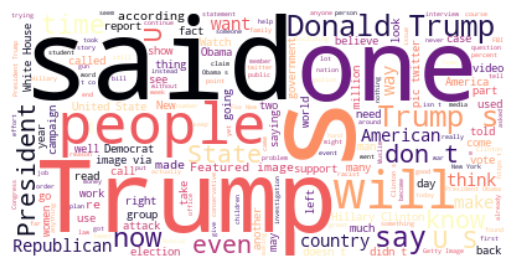

In [68]:
plt.imshow(wordcloud , interpolation='bilinear',)
plt.axis("off")
plt.title('Fake News WordCloud')
plt.show()

# <span style="color:blue">Interpreting True News Word Cloud</span>

## <span style="color:green">Focus on Current Events:</span>
The most prominent words in the word cloud are related to current events, such as "Trump," "NRA," "Thursday," "New York," and "election." This suggests that true news articles often focus on recent developments and important issues.

## <span style="color:green">Neutral Language:</span>
The language used in the word cloud is mostly neutral, with words like "meeting," "people," "statement," "said," and "issue." This suggests that true news articles avoid using emotional language or making claims that are not supported by evidence.

## <span style="color:green">Variety of Sources:</span>
The word cloud includes words like "CNN," "BBC," and "AP," which suggests that true news articles come from a variety of sources. This is important for ensuring that you are getting a well-rounded view of the news.

## <span style="color:green">Factual Language:</span>
The word cloud includes words like "deal," "rule," and "percent," which suggests that true news articles often focus on facts and figures. This helps to make the news more objective and reliable.


In [69]:
text= " ".join(text for text in df_train.loc[df_train['Label']=='True', "text"])
wordcloud= WordCloud(background_color="white", max_words=200, colormap = "magma").generate(text)

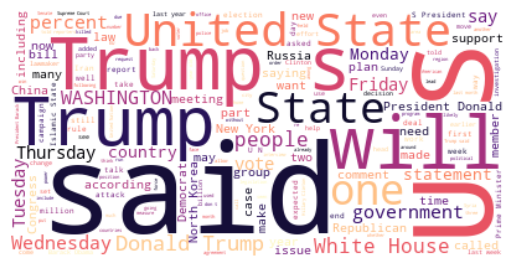

In [70]:
plt.imshow(wordcloud , interpolation='bilinear',)
plt.axis("off")
plt.title('True News WordCloud')
plt.show()

# <span style="color:blue">All News Word Cloud</span>


In [ ]:
text= " ".join(text for text in X)
wordcloud= WordCloud(background_color="white", max_words=200, colormap = "magma").generate(text)
plt.imshow(wordcloud , interpolation='bilinear', )
plt.axis("off")
plt.show()

# Saving the Model

In [ ]:
y_final= y
X_final=X

In [ ]:
random_forest_pipeline = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rfc_model',RandomForestClassifier())
        ])

In [ ]:
random_forest_pipeline.fit(X_final, y_final)

In [ ]:

model_file = "rfc_pipe.sav"  

with open(model_file, 'wb') as file:  
    pickle.dump(random_forest_pipeline, file, protocol=pickle.HIGHEST_PROTOCOL)